Composite nodes
=====================

From the outside, a `CompositeNode` behaves like any other `Node`, and it can be viewed as the implementation of a black box.

Internally, the `CompositeNode` consists of a `FactorGraph` of its own, and a message passing algorithm can be executed on this internal graph to implement the desired node functon. Terminal nodes in the internal graph might be connected to interfaces of the composite node, which in turn connect to the outside world (higher level graph). Aside from these connections, the internal graph is a regular `FactorGraph`, and it does not require any further knowledge about what goes on outside the composite node.

This implementation allows for complex and nested models that can easily be extended. In this notebook, we demonstrate how to construct a `CompositeNode` from a factor graph, and whe demonstrate the use of custom computation rules.

## Creating a composite node


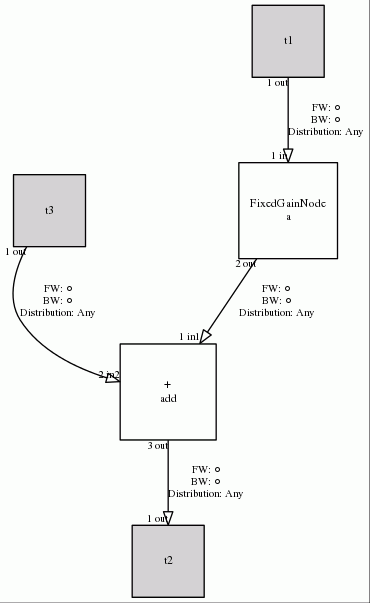

In [1]:
using ForneyLab

# Build a graph
g = currentGraph()
PriorNode(id=:t1)
FixedGainNode(2.0; id=:a)
AdditionNode(id=:add)
TerminalNode(DeltaDistribution(3.0); id=:t3)
TerminalNode(id=:t2)
Edge(n(:t1), n(:a).i[:in])
Edge(n(:a).i[:out], n(:add).i[:in1])
Edge(n(:t3), n(:add).i[:in2])
Edge(n(:add).i[:out], n(:t2))
draw()

This graph implements `t2 = 2.0 * t1 + t3`. Now we can wrap this factor graph into a composite node by calling the `CompositeNode` constructor. In this case, nodes `t1` and `t2` should be connected to interfaces of the composite node.

In [2]:
# Wrap the graph in a composite node
CompositeNode(g, n(:t1), n(:t2); id=:comp)

CompositeNode with id comp


Now we can immediately use our freshly created composite node to contruct a new (higher level) graph. The names of the terminal nodes determine  the names of the interfaces of `comp_node`.


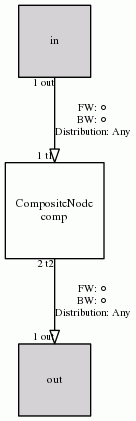

In [3]:
# Specify the top level graph
PriorNode(GaussianDistribution(m=1.5, V=5.0); id=:in)
TerminalNode(id=:out)
Edge(n(:in), n(:comp).i[:t1])
Edge(n(:comp).i[:t2], n(:out))
draw()

In [4]:
# Specify and run the top-level algorithm
algo = SumProduct.Algorithm(n(:comp).i[:t2])
run(algo)

Message{GaussianDistribution} with payload N(m=[6.00], V=[[20.00]])



## Adding a custom computation rule

Now suppose we have a more complicated case. We want to create a composite node from a loopy graph which requires the iterative execution of a message passing schedule before it outputs the correct result. Let us first define the internal graph, which is similar to the graph in the loopy demo.


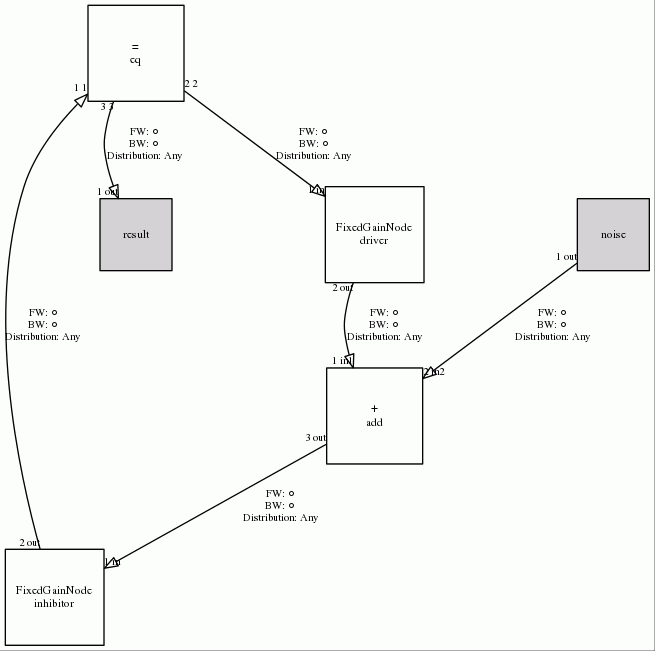

In [5]:
# Build a new graph
g2 = FactorGraph()
FixedGainNode([1.1], id=:driver)
EqualityNode(id=:eq)
TerminalNode(id=:result)
FixedGainNode([0.1], id=:inhibitor)
PriorNode(id=:noise)
AdditionNode(id=:add)
Edge(n(:add).i[:out], n(:inhibitor).i[:in])
Edge(n(:inhibitor).i[:out], n(:eq).i[1])
Edge(n(:eq).i[2], n(:driver).i[:in])
Edge(n(:eq).i[3], n(:result).i[:out])
Edge(n(:driver).i[:out], n(:add).i[:in1])
Edge(n(:noise).i[:out], n(:add).i[:in2])
draw()

Next we define a custom calculation rule (`exec`) and wrap it in an `Algorithm` that calculates the message towards `result`.

In [6]:
# Set vague breaker messages
setMessage!(n(:eq).i[1], Message(vague(GaussianDistribution)))
setMessage!(n(:eq).i[2], Message(vague(GaussianDistribution)))
schedule = SumProduct.generateSchedule(n(:result).i[:out].partner) # Generate the schedule based on the set breaker messages

# Define custom update function that executes the schedule ten times
function exec_ten_times(fields)
    for itr = 1:10
        execute(fields[:schedule])
    end
end

# Wrap the iterative sum-product algorithm in an Algorithm object
algo_internal = Algorithm(exec_ten_times, {:schedule => schedule});

All this is still performed without constructing a composite node. That's what we're going to do next, and we immediately add our custom rule.

In [7]:
# Wrap the graph in a composite node
CompositeNode(g2, n(:noise), n(:result); id=:comp2)
# Add our custom sum-product update rule for the message towards the result interface
addRule!(n(:comp2), n(:comp2).i[:result], sumProduct!, algo_internal);

We again use our custom node to build a graph and infer the result we're interested in.


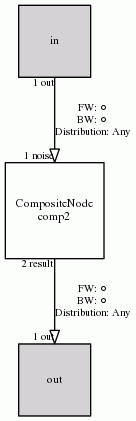

In [8]:
# Specify the higher-level graph
PriorNode(GaussianDistribution(m=1.5, V=5.0); id=:in)
TerminalNode(id=:out)
Edge(n(:in), n(:comp2).i[:noise])
Edge(n(:comp2).i[:result], n(:out))
draw()

In [9]:
# Specify and run the algorithm
algo2 = SumProduct.Algorithm(n(:comp2).i[:result])
run(algo2)

Message{GaussianDistribution} with payload N(ξ=[1.24e-11], W=[[8.27e-11]])

